# Conformal prediction for return

## Toy example:  Example 3 in Rowland et al.(2023)

state space: $s \in \{x_1, x_2\}$ 

inital state distribution: $Pr(s_0 = x_1) = Pr(s_0 = x_2) = 0.5$

transition dynamics:<br>
$Pr(s_{t+1} = x_1|s_t= x_1) = 0.6, \quad Pr(s_{t+1} = x_2|s_t= x_1) = 0.4,$ <br>
$Pr(s_{t+1} = x_1|s_t= x_2) = 0.8, \quad Pr(s_{t+1} = x_2|s_t= x_2) = 0.2$

reward distribution: The reward obtained when transitioning from state $x_1$ is distributed as N(2, 1), and the reward obtained when transitioning from state $x_2$ is distributed as N(-1, 1);

discount factor: $\gamma = 0.5$


In [1]:
## data generation model

import numpy as np
import math
import os
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
import random
from joblib import Parallel, delayed

In [2]:
##parameter setting
trans_mat=np.array([[0.6,0.4],[0.8,0.2]])
trans_mat_new=np.array([[0.5,0.5],[0.7,0.3]])
trans_mat_new=trans_mat

In [3]:
#################################
###### move one step forward ####
#################################


def step(last_obs):
    # last_obs: last observation of state

    if last_obs == 1:
        a = np.random.binomial(1, p=trans_mat[0,1])
        r = np.random.normal(2, 1)  # reward at the same stage
        s_next = a + 1  # next state
    elif last_obs == 2:
        a = np.random.binomial(1, p=trans_mat[1,1])
        r = np.random.normal(-1, 1)
        s_next = a + 1

    return (a, r, s_next)

def step_new(last_obs):
    # last_obs: last observation of state
    if last_obs == 1:
        a = np.random.binomial(1, p=trans_mat_new[0,1])
        r = np.random.normal(2, 1)  # reward at the same stage
        s_next = a + 1  # next state
    elif last_obs == 2:
        a = np.random.binomial(1, p=trans_mat_new[1,1])
        r = np.random.normal(-1, 1)
        s_next = a + 1

    return (a, r, s_next)

In [4]:
#################################
#### generate one trajectory ####
#################################


def gen_traj(T, gam, seed=None, s_init=None):
    # seed: random seed
    # s_init: initial state
    # gam: discount
    # T: iterative number

    # initialize the state
    if seed is None and s_init is None:
        s = np.random.binomial(1, p=0.5) + 1
    elif seed is not None:
        np.random.seed(seed)
        s = np.random.binomial(1, p=0.5) + 1
    if s_init is not None:
        s = s_init

    s_traj = [s]
    a_traj = []
    r_traj = []

    ret = 0
    for i in range(T):
        a, r, s_next = step(s)
        s_traj.append(s_next)
        a_traj.append(a)
        r_traj.append(r)
        s = s_next  # update current S as S_next
        ret += r * gam**i

    ## output state, reward trajectory. return
    return [s_traj, a_traj, r_traj, ret]




In [5]:
#######################
#### generate data ####
#######################


def data_gen(N, T_obs, T, gam, seed=None, s_init=None):
    # N: number of trajectories
    # T_obs: observed stage numbers

    s_data = np.zeros((N, T_obs), dtype=int)
    a_data = np.zeros((N, T_obs), dtype=int)
    r_data = np.zeros((N, T_obs))
    ret_data = []

    for i in range(N):
        if seed is not None:
            seed += 1
        tmp = gen_traj(T, gam, seed, s_init)
        s_data[i] = tmp[0][0:T_obs]  # store the i-th state trajectory
        a_data[i] = tmp[1][0:T_obs]
        r_data[i] = tmp[2][0:T_obs]  # store the i-th reward trajectory
        ret_data.append(tmp[3])

    ## output observed state, reward trajectory and true return
    return [s_data, a_data ,r_data, ret_data]



## New method

Step 1: 利用distributional RL构造nonconformity score<br>
当给定初始状态为$s$时，return的条件$\alpha$分位数$Q(s,\alpha)$，$\alpha\sim$U(0,1)和从$s$出发的return有相同分布。<br>
记$\tau_i = \frac{2i-1}{2m}$, 用
$$ \hat F(x|s) = \frac1m \sum_{i=1}^m I\left\{x \le Q\left(s,\tau_i\right)\right\}$$
代替return的条件分布函数。<br>
将数据随机均分为两份，在其中一份上选用Quantile temperal difference(Rowland et al., 2023)拟合条件分位数模型。<br>
nonconformity score: $|r + \gamma \hat Q(s',\alpha)-\hat V(s)|$, $s'$为下一时刻的状态，$\hat V$为$\hat F$的均值，可以作为价值函数的估计。

In [7]:
####################################
### Quantile temperal difference ###
####################################


def QTD(state_traj,
        action_traj,
        reward_traj,
        state_card,
        action_card,
        quantile_num,
        gam,
        rate=None,
        init_val=None):
    # obs_traj: training data
    # state_card: cardinality of state space
    ## quantile_num: number of target conditional quantiles for each state
    # rate: learning rate
    # init_val: initial value

    if init_val == None:
        ret_con_quantile = np.zeros((state_card,action_card, quantile_num))
    elif init_value is not None:
        ret_con_quantile = init_value
    if rate == None:
        rate = 0.1

    #ret_con_quantile = np.zeros((state_card, quantile_num))

    n = np.shape(reward_traj)[0]  ## number of trajectories
    batch_num = np.shape(state_traj)[1] - 1  ## number of (x,r,x') tuples
    tau = [(2 * i + 1) / (2 * quantile_num) for i in range(quantile_num)]
    
    for k in range(n):
        for l in range(batch_num):
            for i in range(quantile_num):    
                s_current = state_traj[k, l]
                a_current = action_traj[k, l]
                r_current = reward_traj[k, l]
                s_next = state_traj[k, l + 1]
                a_next = action_traj[k, l + 1]
                #j = np.random.randint(0, quantile_num - 1)
                #ret_con_quantile[s_current - 1, i] += rate * tau[i] - rate * (
                #    r_current + gam * ret_con_quantile[s_next - 1, j] -
                #    ret_con_quantile[s_current - 1, i] < 0)
                ret_con_quantile[s_current - 1, a_current, i] +=  rate * np.mean(
                    [tau[i] - 1 * (r_current + gam * 
                                      ret_con_quantile[s_next - 1,a_next, j] - 
                                      ret_con_quantile[s_current - 1, a_current, i] < 0) 
                     for j in range(quantile_num)] 
                )

    ## output conditional quantiles
    return (ret_con_quantile)

In [8]:
## calculate V estimator based on QTD output
def q_hat_f(G_quan):
    return (np.mean(G_quan, axis=2))




## Calibration set from replay buffer

We resample calibration data from replay buffer, and then use weighted conformal prediction.
The weight function $\tilde w(\cdot)$ is an estimator of the density ratio:
$$ \frac{dP_{s_{0}}(s)}{dP_{s_{rb}}(s)}, $$
where $s_{rb}$ is a sample point from replay buffer.


In [9]:
#计算pi_a(a|x)
p1=(trans_mat_new[0,1]/trans_mat_new[0,0])*(trans_mat[0,0]/trans_mat[0,1])
a1=p1/(1+p1)
p2=(trans_mat_new[1,1]/trans_mat_new[1,0])*(trans_mat[1,0]/trans_mat[1,1])
a2=p2/(1+p2)
def step_a(last_obs):
    if last_obs == 1:
        a = np.random.binomial(1, p=a1)
    elif last_obs == 2:
        a = np.random.binomial(1, p=a2)

    return (a)
    
vec_step=np.vectorize(step_a)
mat=np.array([[1-a1,a1],[1-a2,a2]])
weight_mat=trans_mat_new/trans_mat
def weight_calculation_clip(s_vec, a_vec,clip):
    weight=1
    step=np.shape(s_vec)[0]-1
    for i in range(step):
        weight*=weight_mat[s_vec[i]-1,a_vec[i]]
    weight=max(min(clip[1],weight),clip[0])
    return(weight)

In [10]:
## replay buffer+propensity score ratio
def replay_buffer(s_traj, a_traj, r_traj,step_forward,ratio,clip):
    n = np.shape(s_traj)[0]
    p = np.shape(s_traj)[1] - step_forward 
    Mem_state = np.zeros((n*p,step_forward+1),dtype=int)
    Mem_action_a = np.zeros((n*p,step_forward+1),dtype=int)
    Mem_action = np.zeros((n*p,step_forward+1),dtype=int)
    Mem_reward = np.zeros((n*p,step_forward+1))
    idx_weight=[]
    for i in range(n):
        for j in range(p):
            Mem_state[(i*p+j),:] = s_traj[i,j:(j+step_forward+1)]
            Mem_action_a[(i*p+j),:] = vec_step(s_traj[i,j:(j+step_forward+1)])
            Mem_action[(i*p+j),:] = a_traj[i,j:(j+step_forward+1)]
            Mem_reward[(i*p+j),:] = r_traj[i,j:(j+step_forward+1)]
            idx_weight.append(
            weight_calculation_clip(Mem_state[(i*p+j), :], Mem_action[(i*p+j), :],clip) * ratio[Mem_state[(i*p+j), 0]-1]
            )

    total = np.array(idx_weight).sum()
    idx_weight_final=np.array(idx_weight)/total
    return([Mem_state,Mem_action,Mem_reward,idx_weight_final])

##ratio of frequency of s_0/s_rb
def rb(s_traj, a_traj, r_traj,step_forward):
    n = np.shape(s_traj)[0]
    p = np.shape(s_traj)[1] - step_forward 
    Mem_state = np.zeros((n*p,step_forward+1),dtype=int)
    Mem_action_a = np.zeros((n*p,step_forward+1),dtype=int)
    Mem_action = np.zeros((n*p,step_forward+1),dtype=int)
    Mem_reward = np.zeros((n*p,step_forward+1))
    acc_1=0
    acc_2=0
    for i in range(n):
        for j in range(p):
            Mem_state[(i*p+j),:] = s_traj[i,j:(j+step_forward+1)]
            Mem_action_a[(i*p+j),:] = vec_step(s_traj[i,j:(j+step_forward+1)])
            Mem_action[(i*p+j),:] = a_traj[i,j:(j+step_forward+1)]
            Mem_reward[(i*p+j),:] = r_traj[i,j:(j+step_forward+1)]
            if (vec_step(s_traj[i,j:(j+step_forward)])==a_traj[i,j:(j+step_forward)]).all() and Mem_state[(i*p+j),0]==1 :
                acc_1+=1
            elif (vec_step(s_traj[i,j:(j+step_forward)])==a_traj[i,j:(j+step_forward)]).all() and Mem_state[(i*p+j),0]==2 :
                acc_2+=1
    ratio_1=(2*n*p-np.sum(Mem_state[:,0]))/acc_1
    ratio_2=(np.sum(Mem_state[:,0])-n*p)/acc_2
    return([ratio_1,ratio_2])



In [11]:

def weighted_percentile(data, weights, perc):

    data = np.array(data)
    weights = np.array(weights)
    idx = np.argsort(data)
    data = data[idx] # sort data
    weights = weights[idx] # sort weights
    cdf = np.cumsum(weights) / np.sum(weights)
    count = np.sum([ cdf[i] <= perc for i in range(np.shape(cdf)[0]) ])
    #if output=infty return the maximum of V
    if data[count]==float('inf'):
        count-=1
    return(data[count])
    

In [12]:
def scoring(s_traj, r_traj,step_forward,gam,G_quan,v_hat):
    # s_traj: state trajectory
    # r_traj: reward trajectory
    # step_forward: number of steps used in approximating return
    # gam: discount
    if np.shape(s_traj)[1]!=step_forward+1:
        print("length dismatch")
    if np.shape(s_traj)[0]!=np.shape(r_traj)[0]:
        print("height dismatch")
    
    quan_num = np.shape(G_quan)[2]
    n = np.shape(s_traj)[0]
    u = np.random.randint(0, quan_num - 1, size=n)
    sc = list(
        map(
            abs,
            np.sum([gam**i * r_traj[:, i] for i in range(step_forward)],
                   axis=0) +
            [
                gam**step_forward * G_quan[s_traj[i, step_forward] - 1, step_new(s_traj[i, step_forward])[0],u[i]] -
                v_hat[s_traj[i, 0] - 1] for i in range(n)
            ]))

    return (sc)

## 重复实验500次

In [13]:
import itertools

In [13]:
def new_rb_res(data_train, data_test, gam, alp, step_forward, QTD_para,B,tau,seed,sample_size,clip):
    n_tr, n_te = np.shape(data_train[0])[0], np.shape(data_test[0])[0]
    s_init_te = data_test[0]
    a_init_te = data_test[1]
    ret_te = data_test[3]
    
    ## split training data
    idx_perm = np.random.permutation(list(range(0, n_tr)))
    idx_tr, idx_cal = [idx_perm[0:int(n_tr / 2)], idx_perm[int(n_tr / 2):n_tr]]
    s_train_fold = data_train[0][idx_tr,:]
    a_train_fold = data_train[1][idx_tr,:]
    r_train_fold = data_train[2][idx_tr,:]
    
    ## train return distribution using QTD
    G_quan = QTD_new(state_traj=s_train_fold,
                 action_traj=a_train_fold,
                 reward_traj=r_train_fold,
                 state_card=2,
                 action_card=2,
                 quantile_num=QTD_para[0],
                 gam=gam,
                 seed=seed,
                 rate=QTD_para[1],
                 init_val=None)
    Q_hat = q_hat_f(G_quan)
    v_hat=np.zeros(2)
    v_hat[0]=trans_mat_new[0,0]*Q_hat[0,0]+trans_mat_new[0,1]*Q_hat[0,1]
    v_hat[1]=trans_mat_new[1,0]*Q_hat[1,0]+trans_mat_new[1,1]*Q_hat[1,1]


    ## calculate nonconformity scores based on test set
    sc_te = [abs(ret_te[i] - v_hat[s_init_te[i, 0] - 1]) for i in range(n_te)]
    
    ## replay buffer
    l = np.shape(step_forward)[0]
    if isinstance(tau, int) == False:
        m = np.shape(tau)[0]
    elif isinstance(tau, int) == True:
        m = 1
        
    PI_cov_e = np.zeros((m,l))
    PI_len_e = np.zeros((m,l))
            
    p1_s0_estimate = np.mean(s_train_fold[:,0] - 1)

            
        
    for k in range(l):
       
        ratio=rb(s_traj=data_train[0][idx_tr, :],
                    a_traj=data_train[1][idx_tr, :],
               r_traj=data_train[2][idx_tr, :],
                step_forward=step_forward[k])
        ## density ratio
        Mem_1 = replay_buffer(s_traj=s_train_fold,
                              a_traj=a_train_fold,
                              r_traj=r_train_fold,
                              step_forward=1,
                             ratio=np.ones(2),
                             clip=np.ones(2))
        p1_rb = np.mean(Mem_1[0][:,0] - 1)
        dr_s_e = [((1-p1_s0_estimate)/(1-p1_rb))*ratio[0],(p1_s0_estimate/p1_rb)*ratio[1]]
        
        quan_B_e = np.zeros((m,n_te,B))






        
 
        for i in range(B):
            
        #n_cal = np.random.choice(a=[j for j in range(np.shape(Mem[0])[0])], p=p,size=200)
            Mem = replay_buffer(s_traj=data_train[0][idx_cal, :],
                    a_traj=data_train[1][idx_cal, :],
                 r_traj=data_train[2][idx_cal, :],
                step_forward=step_forward[k],
                               ratio=ratio,
                               clip=clip)
            weight_is=Mem[-1]
            n_cal = np.random.choice(range(np.shape(weight_is)[0]),size=sample_size, p=weight_is)
            ## calculate nonconformity scores based on calibration set
            sc_rb = scoring(s_traj=Mem[0][n_cal,],
                            r_traj=Mem[2][n_cal,],
                            step_forward=step_forward[k],
                            gam=gam,
                            G_quan=G_quan,
                            v_hat=v_hat)
            sc_rb.append(float('inf')) 
            for j in range(n_te): 
                for z in range(m):
                    quan_B_e[z][j,i] = weighted_percentile(data=sc_rb,weights=np.ones(sample_size+1),
                                                      perc=1-alp)
                    
        critical_value_rb_e = np.zeros((m,n_te))
 
        for z in range(m):
            critical_value_rb_e[z,:] = [ np.percentile(a=quan_B_e[z][k,:],
                                                           q=tau[z]*100) for k in range(n_te) ]

            
            PI_cov_e[z,k] = np.mean([sc_te[k] <= critical_value_rb_e[z,k] 
                                         for k in range(n_te)])
            PI_len_e[z,k] = 2 * np.mean(critical_value_rb_e[z,:])
            
            
    return([PI_cov_e,PI_len_e])


In [14]:
def quantile_region_res(data_train, data_test, gam, alp, QTD_para,seed):

    n_tr, n_te = np.shape(data_train[0])[0], np.shape(data_test[0])[0]
    s_init_te = data_test[0]
    a_init_te = data_test[1] 
    ret_te = data_test[3]
    quant_num = QTD_para[0]
    ## train QTD using full training data
    G_quan_full = QTD_new(state_traj=data_train[0],
                      action_traj=data_train[1],
                      reward_traj=data_train[2],
                      state_card=2,
                      action_card=2,  
                      quantile_num=quant_num,
                      gam=gam,
                      seed=seed,
                      rate=QTD_para[1],
                      init_val=None)
    quant_interval_lower=np.zeros(2)
    quant_interval_upper=np.zeros(2)

    ## lower and upper quanitles for each states 
    for i in range(2):
        data_aug=np.hstack((G_quan_full[i,0,:], G_quan_full[i,1,:])) 
        weight_aug=np.hstack((np.ones(quant_num)*trans_mat_new[i,0]/quant_num,np.ones(quant_num)*trans_mat_new[i,1]/quant_num))
        quant_interval_lower[i]=weighted_percentile(data_aug,weight_aug,alp/2)
        quant_interval_upper[i]=weighted_percentile(data_aug,weight_aug,1-alp/2)
                       

    ## calculate coverage
    t1 = [
    ret_te[i] >= quant_interval_lower[s_init_te[i, 0] - 1] for i in range(n_te)
    ]
    t2 = [
    ret_te[i] <= quant_interval_upper[s_init_te[i, 0] - 1] for i in range(n_te)
    ]
    quan_PI_cov = np.mean([all([t1[i], t2[i]]) for i in range(n_te)])
    quan_PI_len = np.mean([
        quant_interval_upper[s_init_te[i, 0] - 1] -
        quant_interval_lower[s_init_te[i, 0] - 1] for i in range(n_te)
        ])

    return ([quan_PI_cov, quan_PI_len])

In [15]:
#Parallel Calculation
def run_single_experiment(i, n_tr, gam, T_obs, seed, n_te, T, QTD_para, B, alp, tau, step_forward,sample_size,clip):

    data_train = data_gen(N=n_tr,
                          T_obs=T_obs,
                          T=T,
                          gam=gam,
                          seed=seed + i,
                          s_init=None)


    data_test = data_gen_new(N=n_te,
                             T_obs=1,
                             T=T,
                             gam=gam,
                             seed=seed + i + 10000,
                             s_init=None)

    result = new_rb_res(data_train=data_train,
                        data_test=data_test,
                        gam=gam,
                        alp=alp,
                        step_forward=step_forward,
                        QTD_para=QTD_para,
                        B=B,
                        tau=tau,
                        seed=seed + i,
                        sample_size=sample_size,
                       clip=clip)
   
    return result  # return [PI_cov_e, PI_len_e]




In [ ]:
# Parameter setting
rep = 100
n_tr = 400
gam = 0.8
T_obs = 30
seed = 2025
n_te = 310
T = 70
QTD_para = [20, 0.1]
B = 50
alp = 0.1
tau = [0.2,0.3,0.4,0.5]
clip=np.array([0.2,5.0])
step_forward = [1, 2, 3,4,5]
sample_size=200




results = Parallel(n_jobs=30, verbose=1)(
    delayed(run_single_experiment)(
        i, n_tr, gam, T_obs, seed, n_te, T, QTD_para, B, alp, tau, step_forward, sample_size,clip
    ) for i in range(rep)
)



In [33]:
rb_new_cov_tau01_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau01_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau02_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau02_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau03_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau03_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau04_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau04_e3 = np.zeros((rep, np.shape(step_forward)[0]))
for i in range(np.shape(results)[0]):

    rb_new_cov_tau01_e3[i, :] = results [i][0][0]
    rb_new_len_tau01_e3[i, :] = results [i][1][0]
    rb_new_cov_tau02_e3[i, :] = results [i][0][1]
    rb_new_len_tau02_e3[i, :] = results [i][1][1]
    rb_new_cov_tau03_e3[i, :] = results [i][0][2]
    rb_new_len_tau03_e3[i, :] = results [i][1][2]
    rb_new_cov_tau04_e3[i, :] = results [i][0][3]
    rb_new_len_tau04_e3[i, :] = results [i][1][3]


PI_cov_all = [res[0] for res in results]
PI_len_all = [res[1] for res in results]

In [34]:
print("new(tau=0.2): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau01_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau01_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])


print("new(tau=0.3): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau02_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau02_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])


print("new(tau=0.4): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau03_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau03_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

print("new(tau=0.5): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau04_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau04_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

new(tau=0.1): 
coverage probability: 
[0.8820645161290324, 0.8895483870967741, 0.8915483870967742, 0.8921935483870967, 0.8950322580645163]
average length: 
[6.727893559099994, 6.863006978508485, 6.902510420577609, 6.91913463338389, 6.9569359766338]
new(tau=0.2): 
coverage probability: 
[0.8921612903225805, 0.9001935483870966, 0.9024193548387096, 0.9043870967741934, 0.906032258064516]
average length: 
[6.903011840456324, 7.038433696559764, 7.075001615714122, 7.103650731761804, 7.134154338069956]
new(tau=0.3): 
coverage probability: 
[0.8996774193548387, 0.9075483870967741, 0.9109032258064513, 0.9121612903225806, 0.9138064516129033]
average length: 
[7.028714164147691, 7.165922465601024, 7.217996891328595, 7.239422288179153, 7.278856408721765]
new(tau=0.4): 
coverage probability: 
[0.9054838709677421, 0.9138387096774193, 0.9165483870967742, 0.917258064516129, 0.9189032258064516]
average length: 
[7.13249228067631, 7.285776662150312, 7.336057332894228, 7.358677769521463, 7.398790145405934

In [35]:
import pandas as pd
data_new_rb_cov = {
    'k=1': rb_new_cov_tau01_e3[:,0],
    'k=2': rb_new_cov_tau01_e3[:,1],
    'k=3': rb_new_cov_tau01_e3[:,2],
    'k=4': rb_new_cov_tau01_e3[:,3],
    'k=5': rb_new_cov_tau01_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_simple_01.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau01_e3[:,0],
     'k=2': rb_new_len_tau01_e3[:,1],
     'k=3': rb_new_len_tau01_e3[:,2],
     'k=4': rb_new_len_tau01_e3[:,3],
     'k=5': rb_new_len_tau01_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_simple_01.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [39]:
data_new_rb_cov = {
    'k=1': rb_new_cov_tau02_e3[:,0],
    'k=2': rb_new_cov_tau02_e3[:,1],
    'k=3': rb_new_cov_tau02_e3[:,2],
    'k=4': rb_new_cov_tau02_e3[:,3],
    'k=5': rb_new_cov_tau02_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_simple_02.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau02_e3[:,0],
     'k=2': rb_new_len_tau02_e3[:,1],
     'k=3': rb_new_len_tau02_e3[:,2],
     'k=4': rb_new_len_tau02_e3[:,3],
     'k=5': rb_new_len_tau02_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_simple_02.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [37]:
data_new_rb_cov = {
    'k=1': rb_new_cov_tau03_e3[:,0],
    'k=2': rb_new_cov_tau03_e3[:,1],
    'k=3': rb_new_cov_tau03_e3[:,2],
    'k=4': rb_new_cov_tau03_e3[:,3],
    'k=5': rb_new_cov_tau03_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_simple_03.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau03_e3[:,0],
     'k=2': rb_new_len_tau03_e3[:,1],
     'k=3': rb_new_len_tau03_e3[:,2],
     'k=4': rb_new_len_tau03_e3[:,3],
     'k=5': rb_new_len_tau03_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_simple_03.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [38]:
data_new_rb_cov = {
    'k=1': rb_new_cov_tau04_e3[:,0],
    'k=2': rb_new_cov_tau04_e3[:,1],
    'k=3': rb_new_cov_tau04_e3[:,2],
    'k=4': rb_new_cov_tau04_e3[:,3],
    'k=5': rb_new_cov_tau04_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_simple_04.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau04_e3[:,0],
     'k=2': rb_new_len_tau04_e3[:,1],
     'k=3': rb_new_len_tau04_e3[:,2],
     'k=4': rb_new_len_tau04_e3[:,3],
     'k=5': rb_new_len_tau04_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_simple_04.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [21]:
'''
data_new_rb_cov = {
    'new-rb-1': rb_new_cov_tau06_e3[:,0],
    'new-rb-2': rb_new_cov_tau06_e3[:,1],
    'new-rb-3': rb_new_cov_tau06_e3[:,2],
    'new-rb-4': rb_new_cov_tau06_e3[:,3],
    'new-rb-5': rb_new_cov_tau06_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('output_cov_is_clip_v3_095.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'new-rb-1': rb_new_len_tau06_e3[:,0],
     'new-rb-2': rb_new_len_tau06_e3[:,1],
     'new-rb-3': rb_new_len_tau06_e3[:,2],
     'new-rb-4': rb_new_len_tau06_e3[:,3],
     'new-rb-5': rb_new_len_tau06_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('output_len_is_clip_v3_095.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')
'''

In [27]:
n_tr = 400
gam = 0.8
T_obs = 30
seed = 2025
n_te = 310
T = 70
rep = 100
QTD_para = [20, 0.015]
alp = 0.1

res_quan_500_qnum10 = np.zeros((rep, 2))

# Parallel Calculation
def process_iteration(i,n_tr, gam, T_obs, seed, n_te, T, QTD_para, alp):
 
    data_train = data_gen(N=n_tr,
                         T_obs=T_obs,
                         T=T,
                         gam=gam,
                         seed=seed+i,
                         s_init=None)
    

    data_test = data_gen_new(N=n_te,
                            T_obs=1,
                            T=T,
                            gam=gam,
                            seed=seed + i + 10000,
                            s_init=None)
    

    quan_PI_res1 = quantile_region_res(data_train=data_train,
                                      data_test=data_test, 
                                      gam=gam, 
                                      alp=alp,
                                      QTD_para=QTD_para,
                                      seed=seed+i)
    
    print(f"test num: {i}")
    print("quantile region: ")
    print(f"cov: {quan_PI_res1[0]} | length: {quan_PI_res1[1]}")
    
    return quan_PI_res1



results_qr = Parallel(n_jobs=30)(delayed(process_iteration)(i, n_tr, gam, T_obs, seed, n_te, T, QTD_para, alp) for i in range(rep))

# restore data
for i in range(rep):
    res_quan_500_qnum10[i, :] = results_qr[i]


In [28]:
import pandas as pd

##### save simulation result
data_quan_cov = {
    'quantile region': res_quan_500_qnum10[:, 0]
}

df_cov = pd.DataFrame(data_quan_cov)

df_cov.to_excel('QR_cov_simple_on.xlsx', index=False, engine='openpyxl')

data_quan_len = {
    'quantile region': res_quan_500_qnum10[:, 1]
}

df_len = pd.DataFrame(data_quan_len)

df_len.to_excel('QR_len_simple_on.xlsx', index=False, engine='openpyxl')

print(df_cov.head())
print(df_len.head())

   quantile region
0         0.851613
1         0.858065
2         0.851613
3         0.851613
4         0.851613
   quantile region
0         6.989250
1         7.057908
2         6.953058
3         6.959608
4         7.008846


In [29]:
print("quantile region: ")
print("coverage probability: ", np.mean(res_quan_500_qnum10[:, 0]),
      "|  average length: ", np.mean(res_quan_500_qnum10[:, 1]))

#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

quantile region: 
coverage probability:  0.8624838709677419 |  average length:  6.996038467742023


# 模拟结果图

In [30]:
import pandas as pd

data_new_rb_cov = pd.read_excel('cov_on_simple_02.xlsx')
data_new_rb_len = pd.read_excel('len_on_simple_02.xlsx')

data_QR_cov = pd.read_excel('QR_cov_simple_on.xlsx')
data_QR_len = pd.read_excel('QR_len_simple_on.xlsx')

#data_new_rb_cov.rename(columns={'quantile region': 'QR'}, inplace=True)
#data_new_rb_len.rename(columns={'quantile region': 'QR'}, inplace=True)
data_new_rb_cov['DRL-QR'] = data_QR_cov['quantile region']
data_new_rb_len['DRL-QR'] = data_QR_len['quantile region']

print(data_new_rb_cov.head())
print(data_new_rb_len.head())

        k=1       k=2       k=3       k=4       k=5    DRL-QR
0  0.870968  0.890323  0.880645  0.880645  0.890323  0.851613
1  0.870968  0.877419  0.877419  0.877419  0.893548  0.858065
2  0.877419  0.883871  0.877419  0.896774  0.900000  0.851613
3  0.877419  0.880645  0.877419  0.877419  0.880645  0.851613
4  0.870968  0.890323  0.890323  0.887097  0.887097  0.851613
        k=1       k=2       k=3       k=4       k=5    DRL-QR
0  6.694877  7.029154  6.922169  6.938830  7.059769  6.989250
1  6.687510  7.005146  6.981250  6.892263  7.155193  7.057908
2  6.965559  7.031829  6.959724  7.203303  7.268165  6.953058
3  6.831504  7.061643  6.974636  7.006035  7.026289  6.959608
4  6.742365  7.016473  7.037745  6.972884  6.978426  7.008846


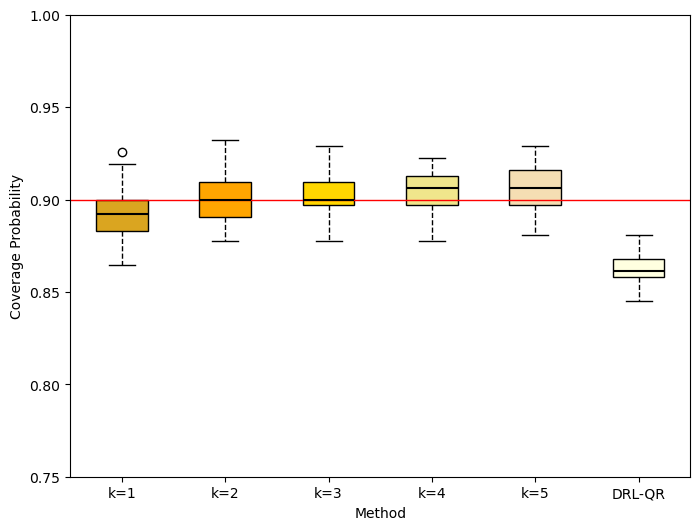

<Figure size 640x480 with 0 Axes>

In [31]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

bplot_new_cov = data_new_rb_cov.boxplot(patch_artist=True,
                         medianprops={
                             'linestyle': '-',
                             'color': 'black',
                             'linewidth': 1.5
                         },
                         whiskerprops={
                             'linestyle': '--',
                             'color': 'black'
                         },
                         capprops={
                             'linestyle': '-',
                             'color': 'black'
                         },
                         boxprops={
                             'linestyle': '-',
                             'color': 'black'
                         })

colors = [
    'goldenrod', 'orange', 'gold', 'khaki', 'wheat', 'lightyellow','skyblue'
]

colors2 = [
    'darkseagreen','limegreen' ,'greenyellow','yellowgreen','lightgreen','honeydew','skyblue'
]
for patch, color in zip(bplot_new_cov.patches, colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1)

bplot_new_cov.yaxis.grid(False)
bplot_new_cov.xaxis.grid(False)
bplot_new_cov.set_xlabel("Method")
bplot_new_cov.set_ylabel("Coverage Probability")

plt.axhline(y=0.90, color='red', linestyle='-', linewidth=1)
#plt.title("tau=0.9, n_tr=600, gam=0.8, quantnum=30, p_s0 estimator")
plt.ylim(0.75,1)
#plt.savefig('fig/new_rb_cov_o_gam0.8_nr100_qnum10.png')
plt.savefig('Ex1_on_policy_cp.png')
plt.show()


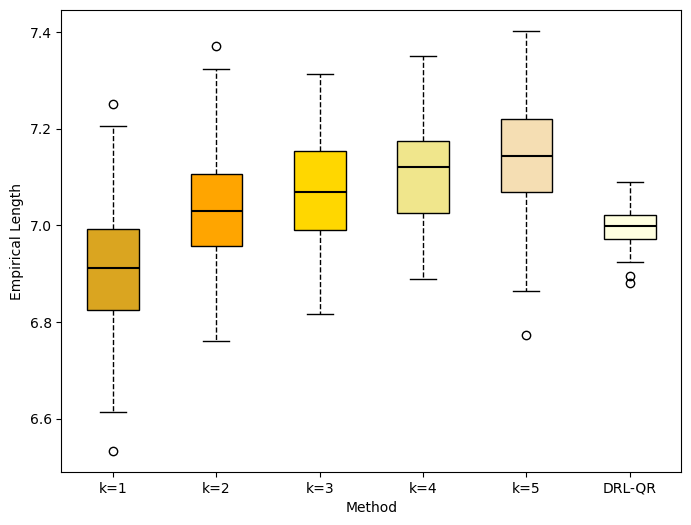

<Figure size 640x480 with 0 Axes>

In [32]:
plt.figure(figsize=(8, 6))

bplot_new_len = data_new_rb_len.boxplot(patch_artist=True,
                         medianprops={
                             'linestyle': '-',
                             'color': 'black',
                             'linewidth': 1.5
                         },
                         whiskerprops={
                             'linestyle': '--',
                             'color': 'black'
                         },
                         capprops={
                             'linestyle': '-',
                             'color': 'black'
                         },
                         boxprops={
                             'linestyle': '-',
                             'color': 'black'
                         })


for patch, color in zip(bplot_new_len.patches, colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1)

bplot_new_len.yaxis.grid(False)
bplot_new_len.xaxis.grid(False)
bplot_new_len.set_xlabel("Method")
bplot_new_len.set_ylabel("Empirical Length")

#plt.title("tau=0.9, n_tr = 600, gam=0.8, quantnum=30, p_s0 estimator")
#plt.savefig('fig/new_len_o_gam0.8_nr100_qnum10.png')
plt.show()
plt.savefig(''Ex1_on_policy_al.png')